In [36]:
import os

import numpy as np
import pandas as pd

import glob

import time
from tqdm import tqdm

import librosa
import librosa.display
import soundfile as sf # librosa fails when reading files on Kaggle.


import matplotlib.pyplot as plt
import IPython.display as ipd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

In [18]:
file_names = glob.glob("./AnnotatedAudioFiles/*.wav")
file_names = sorted(file_names)

In [19]:
print(file_names)

['./AnnotatedAudioFiles/code0_dating-violence_01.wav', './AnnotatedAudioFiles/code0_dating-violence_02.wav', './AnnotatedAudioFiles/code0_dating-violence_03.wav', './AnnotatedAudioFiles/code0_dating-violence_04.wav', './AnnotatedAudioFiles/code0_dating-violence_05.wav', './AnnotatedAudioFiles/code0_dating-violence_06.wav', './AnnotatedAudioFiles/code0_dating-violence_07.wav', './AnnotatedAudioFiles/code0_dating-violence_08.wav', './AnnotatedAudioFiles/code0_dating-violence_09.wav', './AnnotatedAudioFiles/code0_dating-violence_10.wav', './AnnotatedAudioFiles/code0_dating-violence_11.wav', './AnnotatedAudioFiles/code0_dating-violence_12.wav', './AnnotatedAudioFiles/code0_dating-violence_13.wav', './AnnotatedAudioFiles/code0_dating-violence_14.wav', './AnnotatedAudioFiles/code0_dating-violence_15.wav', './AnnotatedAudioFiles/code0_dating-violence_16.wav', './AnnotatedAudioFiles/code0_dating-violence_17.wav', './AnnotatedAudioFiles/code0_dating-violence_18.wav', './AnnotatedAudioFiles/code

In [25]:
to_df = []
for f in file_names:
    tmp = f.split('/')[2].split('_')[0]
    if tmp == 'code5':
        to_df.append([f, tmp, 'normal'])
    else:
        to_df.append([f, tmp, 'violence'])

In [28]:
df = pd.DataFrame(to_df, columns=['path', 'code', 'label'])

In [29]:
df

,path,code,label
0,./AnnotatedAudioFiles/code0_dating-violence_01...,code0,violence
1,./AnnotatedAudioFiles/code0_dating-violence_02...,code0,violence
2,./AnnotatedAudioFiles/code0_dating-violence_03...,code0,violence
3,./AnnotatedAudioFiles/code0_dating-violence_04...,code0,violence
4,./AnnotatedAudioFiles/code0_dating-violence_05...,code0,violence
...,...,...,...
1667,./AnnotatedAudioFiles/code5_normal_3(time9000t...,code5,normal
1668,./AnnotatedAudioFiles/code5_normal_3(time900to...,code5,normal
1669,./AnnotatedAudioFiles/code5_normal_3(time9300t...,code5,normal
1670,./AnnotatedAudioFiles/code5_normal_3(time9600t...,code5,normal


In [37]:
def mean_mfccs(x):
    return [np.mean(feature) for feature in librosa.feature.mfcc(x)]

def parse_audio(x):
    return x.flatten('F')[:x.shape[0]] 

def get_audios():
    train_file_names = df['path']
    samples = []
    for file_name in tqdm(train_file_names):
        x, sr = sf.read(file_name, always_2d=True)
        if not len(x) == 0:
            x = parse_audio(x)
            samples.append(mean_mfccs(x))
        else:
            print(file_name)
    return np.array(samples)

def get_samples():
    return get_audios(), df['label'].values

In [38]:
X, Y = get_samples()

# Since the data manufacturer doesn't provide the labels for the test audios,
# we will have do the split for the labeled data.
x_train, x_test, y_train, y_test = train_test_split(X, Y)

100%|██████████| 1672/1672 [09:01<00:00,  3.09it/s]


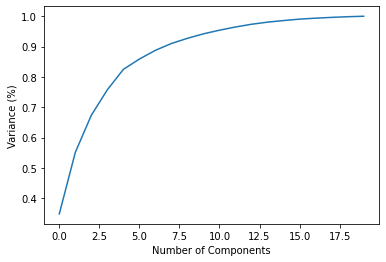

In [39]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

pca = PCA().fit(x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.show()

In [40]:
grid_params = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

model = GridSearchCV(KNeighborsClassifier(), grid_params, cv=5, n_jobs=-1)
model.fit(x_train_scaled, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [3, 5, 7, 9, 11, 15],
                         'weights': ['uniform', 'distance']})

In [41]:
print(f'Model Score: {model.score(x_test_scaled, y_test)}')

y_predict = model.predict(x_test_scaled)
print(f'Confusion Matrix: \n{confusion_matrix(y_predict, y_test)}')

Model Score: 1.0
Confusion Matrix: 
[[ 41   0]
 [  0 377]]


In [42]:
set(y_predict)

{'normal', 'violence'}